<a href="https://colab.research.google.com/github/patty-13/DEEP_LEARNING_NJIT/blob/main/HW10_DEEPLEARNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 10 - Reinforcement Learning**




## Preliminary work

First, we need to install all necessary packages.
One of them, gym, builded by OpenAI, is a toolkit for developing Reinforcement Learning algorithm. Other packages are for visualization in colab.

In [ ]:
!apt update
!pip install -q swig
!pip install box2d==2.3.2 gym[box2d]==0.25.2 box2d-py pyvirtualdisplay tqdm numpy==1.22.4
!pip install box2d==2.3.2 box2d-kengz
!pip freeze > requirements.txt

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
15 packages can be upgraded. Run 'apt list --upgradable' to see them.
  Using cached Box2D-2.3.2.tar.gz (427 kB)
  Preparing metadata (setup.py) ... done
  Using cached

  Using cached Box2D-kengz-2.3.3.tar.gz (425 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-kengz: filename=Box2D_kengz-2.3.3-cp310-cp310-linux_x86_64.whl size=2391349 sha256=f8e9b0e28bb2b93b4c6331b4b48558b2b5c0e445a96eab1adfb9b1d2f6e7993b
  Stored in directory: /root/.cache/pip/wheels/ab/a3/5f/6396406aa0163da86c2a8d28304a120b55cfa98363654d853b
Successfully built box2d-kengz


In [ ]:
!apt install xvfb -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.



Next, set up virtual display，and import all necessaary packages.

In [ ]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# Warning ! Do not revise random seed !!!
Make your HW result to be reproducible.


In [ ]:
seed = 2023 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(seed)

Last, call gym and build an [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) environment.

In [ ]:
%%capture
import gym
import random
env = gym.make('LunarLander-v2')
fix(env, seed) # fix the environment Do not revise this !!!

## What Lunar Lander？

“LunarLander-v2”is to simulate the situation when the craft lands on the surface of the moon.

This task is to enable the craft to land "safely" at the pad between the two yellow flags.
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

"LunarLander-v2" actually includes "Agent" and "Environment".

In this homework, we will utilize the function `step()` to control the action of "Agent".

Then `step()` will return the observation/state and reward given by the "Environment".

### Observation / State

First, we can take a look at what an Observation / State looks like.

In [ ]:
print(env.observation_space)

Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)



`Box(8,)`means that observation is an 8-dim vector
### Action

Actions can be taken by looks like

In [ ]:
print(env.action_space)

Discrete(4)


`Discrete(4)` implies that there are four kinds of actions can be taken by agent.
- 0 implies the agent will not take any actions
- 2 implies the agent will accelerate downward
- 1, 3 implies the agent will accelerate left and right

Next, we will try to make the agent interact with the environment.
Before taking any actions, we recommend to call `reset()` function to reset the environment. Also, this function will return the initial state of the environment.

In [ ]:
initial_state = env.reset()
print(initial_state)

[-0.00506535  1.413064   -0.5130838   0.09527162  0.00587628  0.11622101
  0.          0.        ]


Then, we try to get a random action from the agent's action space.

In [ ]:
random_action = env.action_space.sample()
print(random_action)

1


More, we can utilize `step()` to make agent act according to the randomly-selected `random_action`.
The `step()` function will return four values:
- observation / state
- reward
- done (True/ False)
- Other information

In [ ]:
observation, reward, done, info = env.step(random_action)

In [ ]:
print(done)

False


### Reward


> Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100-140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points.

In [ ]:
print(reward)

-1.4981841929643156


### Random Agent
In the end, before we start training, we can see whether a random agent can successfully land the moon or not.

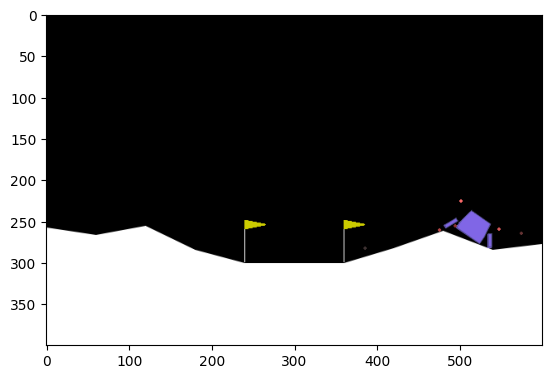

In [ ]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

DQN

In [ ]:
class DQN(nn.Module):
  """Actor (Policy) Model."""

  def __init__(self, state_size=8, action_size=4, fc1_units=64, fc2_units=64):

    """Initialize parameters and build model.
    Params
    ======
        state_size (int): Dimension of each state
        action_size (int): Dimension of each action
        seed (int): Random seed
        fc1_units (int): Number of nodes in first hidden layer
        fc2_units (int): Number of nodes in second hidden layer
    """
    super(DQN, self).__init__()
    self.fc1 = nn.Linear(state_size, fc1_units)
    self.fc2 = nn.Linear(fc1_units, fc2_units)
    self.fc3 = nn.Linear(fc2_units, action_size)

  def forward(self, state):
    """Build a network that maps state -> action values."""
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    return self.fc3(x)

In [ ]:
from collections import namedtuple

class ReplayMemory:
  """Fixed-size buffer to store experience tuples."""
  def __init__(self, CAPACITY):
    self.capacity = CAPACITY
    self.memory = []
    self.index = 0
    self.transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

  def push(self, state, action, state_next, reward):
    """Push a new experience to memory."""
    if len(self.memory) < self.capacity:
        self.memory.append(None)

    self.memory[self.index] = self.transition(state, action, state_next, reward)

    self.index = (self.index + 1) % self.capacity

  def sample(self, batch_size):
    """Randomly sample a batch of experiences from memory."""
    return random.sample(self.memory, batch_size)

  def __len__(self):
    """Return the current size of internal memory."""
    return len(self.memory)

In [ ]:
class DQNAgent():
  """Interacts with and learns from the environment."""
  def __init__(self, num_states, num_actions):
    """Initialize an Agent object."""

    self.num_states = num_states
    self.num_actions = num_actions

    # Replay memory
    self.memory_capacity = 10000
    self.memory = ReplayMemory(self.memory_capacity)

    # Q-Network
    self.main_q_network = DQN()
    self.target_q_network = DQN()

    # optimizer
    self.optimizer = optim.RMSprop(self.main_q_network.parameters(), lr=1e-4)
    # self.optimizer = optim.Adam(self.main_q_network.parameters(), lr=1e-4)


  def update_q_function(self):
    '''update q function'''

    # no enough samples, just return
    if len(self.memory) < BATCH_SIZE:
        return
    # If enough samples are available in memory, get random subset and learn
    self.batch, self.state_batch, self.action_batch, self.reward_batch, self.non_final_next_states = self.make_minibatch()

    self.expected_state_action_values = self.get_expected_state_action_values()

    self.update_main_q_network()

  def make_minibatch(self):
    '''Creating a mini-batch'''

    transitions = self.memory.sample(BATCH_SIZE)

    Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
    batch = Transition(*zip(*transitions))


    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                        if s is not None])

    return batch, state_batch, action_batch, reward_batch, non_final_next_states

  def get_expected_state_action_values(self):
    '''calculate Q（St,at）'''

    self.main_q_network.eval()
    self.target_q_network.eval()

    self.state_action_values = self.main_q_network(
        self.state_batch).gather(1, self.action_batch)

    non_final_mask = torch.BoolTensor(tuple(map(lambda s: s is not None,
                                                self.batch.next_state)))
    # set all state to 0
    next_state_values = torch.zeros(BATCH_SIZE)

    next_state_values[non_final_mask] = self.target_q_network(
        self.non_final_next_states).max(1)[0].detach()
    # DQN formula
    expected_state_action_values = self.reward_batch + GAMMA * next_state_values

    return expected_state_action_values

  def get_action(self, state, episode, test=False):
    """Returns actions for given state as per current policy."""
    if test:
      self.main_q_network.eval()
      with torch.no_grad():
        action = self.main_q_network(torch.from_numpy(state).unsqueeze(0)).max(1)[1].view(1, 1)
      return action.item()
    global steps_done
    epsilon = EPS_END + (EPS_START - EPS_END) * \
            np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if epsilon <= np.random.uniform(0, 1):
      self.main_q_network.eval()
      with torch.no_grad():
        action = self.main_q_network(state).max(1)[1].view(1, 1)
    else:
      action = torch.LongTensor(
          [[random.randrange(self.num_actions)]])
    return action

  def update_main_q_network(self):

    '''update main q net'''
    self.main_q_network.train()
    loss = F.smooth_l1_loss(self.state_action_values,
                            self.expected_state_action_values.unsqueeze(1))

    # update
    self.optimizer.zero_grad()  # reset gradient
    loss.backward()  # backpropagation
    for param in self.main_q_network.parameters():
      param.grad.data.clamp_(-1, 1)
    self.optimizer.step()  # update network


  def memorize(self, state, action, state_next, reward):
    '''save state, action, state_next, reward into replay memory'''
    self.memory.push(state, action, state_next, reward)

  def update_target_q_function(self):

    '''synchronize Target Q-Network to Main Q-Network'''
    self.target_q_network.load_state_dict(self.main_q_network.state_dict())

In [ ]:
network = DQN()
agent = DQNAgent(env.observation_space.shape[0], env.action_space.n)

## Policy Gradient
Now, we can build a simple policy network. The network will return one of action in the action space.

In [ ]:
# class PolicyGradientNetwork(nn.Module):

#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(8, 16)
#         self.fc2 = nn.Linear(16, 16)
#         self.fc3 = nn.Linear(16, 4)

#     def forward(self, state):
#         hid = torch.tanh(self.fc1(state))
#         hid = torch.tanh(hid)
#         return F.softmax(self.fc3(hid), dim=-1)

Then, we need to build a simple agent. The agent will acts according to the output of the policy network above. There are a few things can be done by agent:
- `learn()`：update the policy network from log probabilities and rewards.
- `sample()`：After receiving observation from the environment, utilize policy network to tell which action to take. The return values of this function includes action and log probabilities.

In [ ]:
# from torch.optim.lr_scheduler import StepLR
# class PolicyGradientAgent():

#     def __init__(self, network):
#         self.network = network
#         self.optimizer = optim.SGD(self.network.parameters(), lr=0.002)

#     def forward(self, state):
#         return self.network(state)
#     def learn(self, log_probs, rewards):
#         loss = (-log_probs * rewards).sum() # You don't need to revise this to pass simple baseline (but you can)

#         self.optimizer.zero_grad()
#         loss.backward()
#         self.optimizer.step()

#     def sample(self, state):
#         action_prob = self.network(torch.FloatTensor(state))
#         action_dist = Categorical(action_prob)
#         action = action_dist.sample()
#         log_prob = action_dist.log_prob(action)
#         return action.item(), log_prob

Lastly, build a network and agent to start training.

In [ ]:
# network = PolicyGradientNetwork()
# agent = PolicyGradientAgent(network)

## Training Agent

Now let's start to train our agent.
Through taking all the interactions between agent and environment as training data, the policy network can learn from all these attempts,

In [ ]:
EPISODE_PER_BATCH = 10
NUM_BATCH = 1000
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.01
EPS_DECAY = 500

best_score = 0
best_batch = 0


agent.main_q_network.train()
agent.target_q_network.train()
steps_done = 0

avg_total_rewards, avg_final_rewards = [], []

prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:

  rewards = []
  total_rewards, final_rewards = [], []


  for episode in range(EPISODE_PER_BATCH):

    observation = env.reset()
    state = observation
    state = torch.from_numpy(state).type(
            torch.FloatTensor)
    state = torch.unsqueeze(state, 0)
    total_reward, total_step = 0, 0

    while True:


      action = agent.get_action(state, batch)

      observation_next, reward, done, _ = env.step(action.item())

      total_reward += reward
      total_step += 1
      rewards.append(reward)
      if done:
        state_next = None

      else:

        state_next = observation_next
        state_next = torch.from_numpy(state_next).type(
                torch.FloatTensor)
        state_next = torch.unsqueeze(state_next, 0)


      agent.memorize(state, action, state_next, torch.FloatTensor([reward]))


      agent.update_q_function()


      state = state_next

      if done:
        final_rewards.append(reward)
        total_rewards.append(total_reward)
        break

  avg_total_reward = sum(total_rewards) / len(total_rewards)
  avg_final_reward = sum(final_rewards) / len(final_rewards)
  avg_total_rewards.append(avg_total_reward)
  avg_final_rewards.append(avg_final_reward)
  prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")
  agent.update_target_q_function()
  print("torch.from_numpy(rewards) looks like ", torch.from_numpy(np.array(rewards)).size())


    ### testing

  fix(env, seed)
  agent.main_q_network.eval()
  NUM_OF_TEST = 5 # Do not revise it !!!!!
  test_total_reward = []
  action_list = []
  for i in range(NUM_OF_TEST):

    actions = []
    state = env.reset()
    total_reward = 0

    done = False
    while not done:
      action = agent.get_action(state, episode=i, test=True)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward
    print(total_reward)
    test_total_reward.append(total_reward)

    action_list.append(actions)
    print("length of actions is ", len(actions))
  print(f"Your final reward is : %.2f"%np.mean(test_total_reward))
  if np.mean(test_total_reward) > 280:

    distribution = {}
    for actions in action_list:

      for action in actions:

        if action not in distribution.keys():
            distribution[action] = 1
        else:
          distribution[action] += 1
    PATH = "Action_List_test" + str(batch) + ".npy"
    np.save(PATH ,np.array(action_list))
    if np.mean(test_total_reward) > best_score:
      best_score = np.mean(test_total_reward)
      best_batch = batch
      print('Improve to score %.2f at batch %d'% (best_score, best_batch ))

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.from_numpy(rewards) looks like  torch.Size([1531])
277.915075967029
length of actions is  229


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


298.32184457366236
length of actions is  210
254.33603221587387
length of actions is  231
283.4996510862022
length of actions is  230
12.266557530845674
length of actions is  161
Your final reward is : 225.27
torch.from_numpy(rewards) looks like  torch.Size([2297])
282.36114750245076
length of actions is  248
52.15413229239664
length of actions is  137
304.4432424182538
length of actions is  169
33.85022126741518
length of actions is  146
223.60852628397913
length of actions is  811
Your final reward is : 179.28
torch.from_numpy(rewards) looks like  torch.Size([2948])
275.03572911345873
length of actions is  242
-9.553016012866294
length of actions is  125
4.283995746692696
length of actions is  103
232.79614663079198
length of actions is  308
268.87082178432297
length of actions is  203
Your final reward is : 154.29
torch.from_numpy(rewards) looks like  torch.Size([2217])
278.04033038327395
length of actions is  225
12.879062379773785
length of actions is  145
250.40366999590748
lengt

<ipython-input-89-b4ccb7a39aa3>:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(PATH ,np.array(action_list))


Streaming output truncated to the last 5000 lines.
length of actions is  99
16.64483836188643
length of actions is  137
11.167010342552658
length of actions is  166
274.53520193052805
length of actions is  186
Your final reward is : 60.53
torch.from_numpy(rewards) looks like  torch.Size([1920])
4.30770113797179
length of actions is  146
15.355615621867429
length of actions is  138
24.575303248566286
length of actions is  147
256.45298759985656
length of actions is  214
3.3558264281579966
length of actions is  127
Your final reward is : 60.81
torch.from_numpy(rewards) looks like  torch.Size([1534])
13.88160496070067
length of actions is  144
19.738091488752204
length of actions is  135
-2.0811368398267547
length of actions is  155
17.498448305509598
length of actions is  131
32.85635359541831
length of actions is  156
Your final reward is : 16.38
torch.from_numpy(rewards) looks like  torch.Size([2048])
-0.2956984720604794
length of actions is  150
7.241672106248032
length of actions is 

KeyboardInterrupt: ignored

In [ ]:
# agent.network.train()  # Switch network into training mode
# EPISODE_PER_BATCH = 5  # update the  agent every 5 episode
# NUM_BATCH = 100        # totally update the agent for 500 time

# avg_total_rewards, avg_final_rewards = [], []

# prg_bar = tqdm(range(NUM_BATCH))
# for batch in prg_bar:

#     log_probs, rewards = [], []
#     total_rewards, final_rewards = [], []

#     # collect trajectory
#     for episode in range(EPISODE_PER_BATCH):

#         state = env.reset()
#         total_reward, total_step = 0, 0
#         seq_rewards = []
#         while True:

#             action, log_prob = agent.sample(state) # at, log(at|st)
#             next_state, reward, done, _ = env.step(action)

#             log_probs.append(log_prob) # [log(a1|s1), log(a2|s2), ...., log(at|st)]
#             # seq_rewards.append(reward)
#             state = next_state
#             total_reward += reward
#             total_step += 1
#             rewards.append(reward) # change here
#             # ! IMPORTANT !
#             # Current reward implementation: immediate reward,  given action_list : a1, a2, a3 ......
#             #                                                         rewards :     r1, r2 ,r3 ......
#             # medium：change "rewards" to accumulative decaying reward, given action_list : a1,                           a2,                           a3, ......
#             #                                                           rewards :           r1+0.99*r2+0.99^2*r3+......, r2+0.99*r3+0.99^2*r4+...... ,  r3+0.99*r4+0.99^2*r5+ ......
#             # hard : implement Actor-Critic
#             if done:
#                 final_rewards.append(reward)
#                 total_rewards.append(total_reward)

#                 break

#     print(f"rewards looks like ", np.shape(rewards))
#     #print(f"log_probs looks like ", np.shape(log_probs))
#     # record training process
#     avg_total_reward = sum(total_rewards) / len(total_rewards)
#     avg_final_reward = sum(final_rewards) / len(final_rewards)
#     avg_total_rewards.append(avg_total_reward)
#     avg_final_rewards.append(avg_final_reward)
#     prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

#     # update agent
#     # rewards = np.concatenate(rewards, axis=0)
#     rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # normalize the reward
#     agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
#     print("logs prob looks like ", torch.stack(log_probs).size())
#     print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

  0%|          | 0/100 [00:00<?, ?it/s]

rewards looks like  (510,)
logs prob looks like  torch.Size([510])
torch.from_numpy(rewards) looks like  torch.Size([510])
rewards looks like  (491,)
logs prob looks like  torch.Size([491])
torch.from_numpy(rewards) looks like  torch.Size([491])
rewards looks like  (1358,)
logs prob looks like  torch.Size([1358])
torch.from_numpy(rewards) looks like  torch.Size([1358])
rewards looks like  (500,)
logs prob looks like  torch.Size([500])
torch.from_numpy(rewards) looks like  torch.Size([500])
rewards looks like  (452,)
logs prob looks like  torch.Size([452])
torch.from_numpy(rewards) looks like  torch.Size([452])
rewards looks like  (388,)
logs prob looks like  torch.Size([388])
torch.from_numpy(rewards) looks like  torch.Size([388])
rewards looks like  (465,)
logs prob looks like  torch.Size([465])
torch.from_numpy(rewards) looks like  torch.Size([465])
rewards looks like  (540,)
logs prob looks like  torch.Size([540])
torch.from_numpy(rewards) looks like  torch.Size([540])
rewards looks

### Training Result
During the training process, we recorded `avg_total_reward`, which represents the average total reward of episodes before updating the policy network.

Theoretically, if the agent becomes better, the `avg_total_reward` will increase.
The visualization of the training process is shown below:  


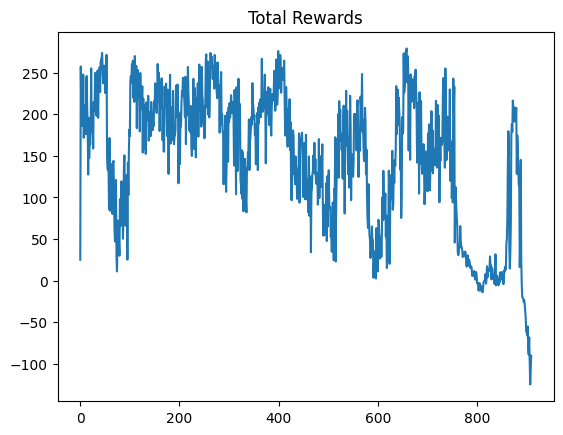

In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

In addition, `avg_final_reward` represents average final rewards of episodes. To be specific, final rewards is the last reward received in one episode, indicating whether the craft lands successfully or not.


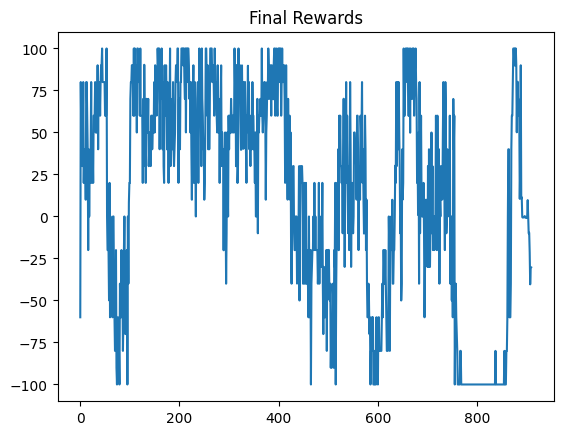

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

## Testing
The testing result will be the average reward of 5 testing

In [ ]:
# fix(env, seed)
# agent.network.eval()  # set the network into evaluation mode
# NUM_OF_TEST = 5 # Do not revise this !!!
# test_total_reward = []
# action_list = []
# for i in range(NUM_OF_TEST):
#   actions = []
#   state = env.reset()

#   img = plt.imshow(env.render(mode='rgb_array'))

#   total_reward = 0

#   done = False
#   while not done:
#       action, _ = agent.sample(state)
#       actions.append(action)
#       state, reward, done, _ = env.step(action)

#       total_reward += reward

#       img.set_data(env.render(mode='rgb_array'))
#       display.display(plt.gcf())
#       display.clear_output(wait=True)

#   print(total_reward)
#   test_total_reward.append(total_reward)

#   action_list.append(actions) # save the result of testing


In [ ]:
print(test_total_reward)
print(np.mean(test_total_reward))

[277.5713884852359, 249.8725182292896, 253.72760937740912, 261.9768367382054, 85.56346320983471]
225.74236320799497


Action list

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action list looks like  [[3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 1, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 0, 0, 0, 2, 0, 2, 3, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 3, 2, 2, 1, 2, 3, 1, 3, 2, 1, 3, 2, 2, 1, 3, 2, 1, 3, 2, 2, 2, 2, 1, 2, 3, 2, 1, 2, 3, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 3, 2, 2, 2, 1, 2, 2, 1, 3, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 2, 1, 1, 1, 0, 2, 2, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 3, 0, 0, 3, 0, 0, 0, 3, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0, 2, 1, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 3, 2, 2, 1, 3, 

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Analysis of actions taken by agent

In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

{3: 169, 1: 128, 0: 292, 2: 484}


In [ ]:
best_batch

356

Saving the result of Model Testing


In [ ]:
PATH = "Action_List_test" + str(best_batch) + ".npy"# Can be modified into the name or path you want
np.save(PATH ,np.array(action_list))

<ipython-input-38-a88282b32115>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(PATH ,np.array(action_list))


In [ ]:
PATH

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Action_List_test330.npy'

### This is the file you need to submit !!!
Download the testing result to your device



In [ ]:
from google.colab import files
files.download(PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Reproduction for Evaluation
The code below simulates the environment and is used for grading.

In [ ]:
action_list = np.load('/content/Action_List_297.npy',allow_pickle=True) # The action list you submit
seed = 2023 # Do not revise this
fix(env, seed)

#agent.network.eval()  # set network to evaluation mode

test_total_reward = []
if len(action_list) != 5:
  print("Wrong format of file !!!")
  exit(0)
for actions in action_list:

  state = env.reset()
  #img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  done_count = 0
  for action in actions:
    state, reward, done, _ = env.step(action)
    done_count += 1
    total_reward += reward
    if done:
      break

  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your reward is : 267.55
Your reward is : 285.34
Your reward is : 310.62
Your reward is : 315.04
Your reward is : 308.42
Your final reward is : 297.39


# Your score

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Your final reward is : 290.41


In [ ]:
#375 274
#356